### ARIMA Model

An ARIMA model is a class of statistical models for analyzing and forecasting time series data. It explicitly caters to a suite of standard structures in time series data, and as such provides a simple yet powerful method for making skillful time series forecasts. ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration. This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:
- AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
- I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
- MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split
from utils import get_apple_close_price, plot_series, rmse, plot_walk_forward_validation

In [2]:
apple_close_price = get_apple_close_price()

In [3]:
train, test= train_test_split(apple_close_price, 
                              test_size=0.05, 
                              shuffle=False)

We need to first find out the best parameters for ARIMA(p, d, q). Let's do a grid search:

In [4]:
import warnings
warnings.simplefilter('ignore')

In [5]:
best_aic = np.inf 
best_order = None

pq_range = range(4) # [0, 1, 2, 3]
d_range = range(3) # [0, 1, 2]

for i in pq_range:
    for d in d_range:
        for j in pq_range:
            try:
                order = (i, d, j)
                tmp_model = ARIMA(train, order=order).fit(disp=0)
                tmp_aic = tmp_model.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = order
                    best_model = tmp_model
            except: continue


print('aic: {:6.2f} | order: {}'.format(best_aic, best_order))

aic: 17689.56 | order: (3, 1, 2)


In [6]:
order = (3, 1, 2)
ARIMAmodel = ARIMA(train, order=order)

In [7]:
ARIMAmodel_fit = ARIMAmodel.fit(disp=0)

In [8]:
print(ARIMAmodel_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 9213
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -8837.780
Method:                       css-mle   S.D. of innovations              0.631
Date:                Mon, 17 Jun 2019   AIC                          17689.561
Time:                        13:40:08   BIC                          17739.460
Sample:                             1   HQIC                         17706.520
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0158      0.007      2.389      0.017       0.003       0.029
ar.L1.D.Close    -1.1426      0.109    -10.449      0.000      -1.357      -0.928
ar.L2.D.Close    -0.8097      0.111     

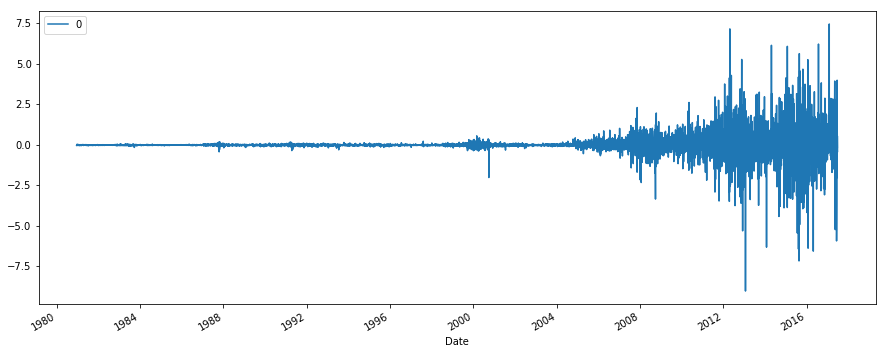

In [9]:
residuals = pd.DataFrame(ARIMAmodel_fit.resid)
residuals.plot(figsize=(15, 6))

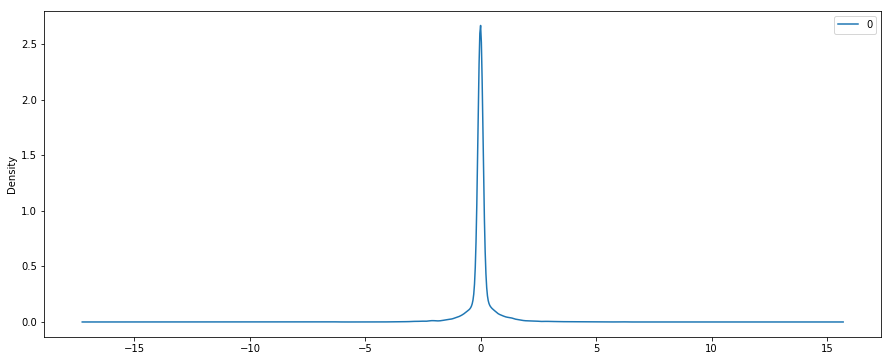

In [10]:
residuals.plot(kind='kde', figsize=(15, 6))

In [11]:
residuals.describe()

,0
count,9.213000e+03
mean,-1.988374e-07
std,6.315283e-01
min,-9.023336e+00
25%,-4.598945e-02
50%,-1.496766e-02
75%,2.287453e-02
max,7.455461e+00


In [12]:
# walk-forward validation
def ARIMA_walk_forward(train, test, order, size=1, steps=1, debug=True):
    history = [x for x in train]
    pred = list()
    limit_range = len(test[:size])

    for t in range(0, limit_range, steps):
        model = ARIMA(history, order=order)
        model_fit = model.fit(disp=0)
        output = model_fit.forecast(steps=steps)
        yhat = output[0]
        pred = pred + yhat.tolist()
        obs = test[t:t+steps]
        history = history + obs.values.tolist()
        
        if debug == True:
            print('predicted={}, expected={}'.format(yhat, obs.values))
            
    return pred

In [13]:
size = 21 # (approx. one month)
predictions = ARIMA_walk_forward(train, test, order, size=size)

predicted=[145.8435553], expected=[143.729996]
predicted=[143.7382968], expected=[145.830002]
predicted=[145.87126311], expected=[143.679993]
predicted=[143.68793203], expected=[144.020004]
predicted=[143.97970912], expected=[143.5]
predicted=[143.6181939], expected=[144.089996]
predicted=[144.03076337], expected=[142.729996]
predicted=[142.74045961], expected=[144.179993]
predicted=[144.26602258], expected=[145.059998]
predicted=[145.04456269], expected=[145.529999]
predicted=[145.50777459], expected=[145.740005]
predicted=[145.81334526], expected=[147.770004]
predicted=[147.77300071], expected=[149.039993]
predicted=[149.05150848], expected=[149.559998]
predicted=[149.56843948], expected=[150.080002]
predicted=[150.0960622], expected=[151.020004]
predicted=[151.05153029], expected=[150.339996]
predicted=[150.32396583], expected=[150.270004]
predicted=[150.28810046], expected=[152.089996]
predicted=[152.17194613], expected=[152.740005]
predicted=[152.70202327], expected=[153.460007]


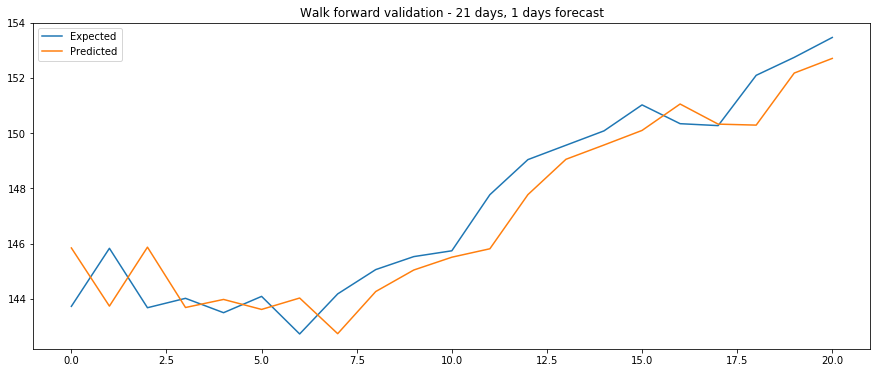

In [14]:
plot_walk_forward_validation(np.array(test), predictions, size)

In [15]:
print('ARIMA[%d days, %d day forecast] - RMSE: %.3f' % (size, 1, rmse(predictions, test[:size])))

ARIMA[21 days, 1 day forecast] - RMSE: 1.202


In [16]:
size = 21 # approx. one month
steps = 3 # 3 days prediction
predictions = ARIMA_walk_forward(train, test, order, size=size, steps=steps)

predicted=[145.8435553  145.89119835 145.87188089], expected=[143.729996 145.830002 143.679993]
predicted=[143.68793203 143.64283101 143.77121683], expected=[144.020004 143.5      144.089996]
predicted=[144.03076337 144.06072462 144.11043154], expected=[142.729996 144.179993 145.059998]
predicted=[145.04456269 145.01497654 145.09061296], expected=[145.529999 145.740005 147.770004]
predicted=[147.77300071 147.76452738 147.7794723 ], expected=[149.039993 149.559998 150.080002]
predicted=[150.0960622  150.11288019 150.11924658], expected=[151.020004 150.339996 150.270004]
predicted=[150.28810046 150.34095768 150.31571544], expected=[152.089996 152.740005 153.460007]


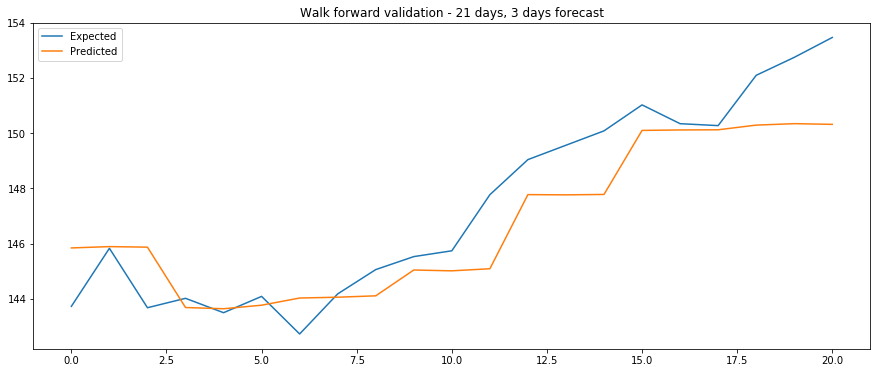

In [17]:
plot_walk_forward_validation(np.array(test), predictions, size, steps)

In [18]:
print('ARIMA[%d days, %d days forecast] - RMSE: %.3f' % (size, steps, rmse(predictions, test[:size])))

ARIMA[21 days, 3 days forecast] - RMSE: 1.543


In [19]:
size = 21 # approx. one month
steps = 7 # 7 days prediction
predictions = ARIMA_walk_forward(train, test, order, size=size, steps=steps)

predicted=[145.8435553  145.89119835 145.87188089 145.9018225  145.9293119
 145.92079075 145.95461228], expected=[143.729996 145.830002 143.679993 144.020004 143.5      144.089996
 142.729996]
predicted=[142.74045961 142.80470584 142.79399358 142.80004549 142.84643339
 142.83441316 142.85648036], expected=[144.179993 145.059998 145.529999 145.740005 147.770004 149.039993
 149.559998]
predicted=[149.56843948 149.57631074 149.59873765 149.61451592 149.62620701
 149.64764187 149.66134764], expected=[150.080002 151.020004 150.339996 150.270004 152.089996 152.740005
 153.460007]


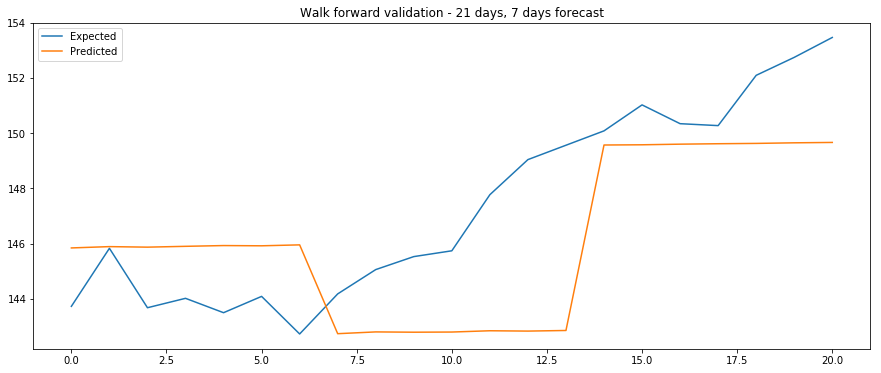

In [20]:
plot_walk_forward_validation(np.array(test), predictions, size, steps)

In [21]:
print('ARIMA[%d days, %d days forecast] - RMSE: %.3f' % (size, steps, rmse(predictions, test[:size])))

ARIMA[21 days, 7 days forecast] - RMSE: 3.062


In [22]:
size = 21 # approx. one month
steps = 21 # 21 days prediction
predictions = ARIMA_walk_forward(train, test, order, size=size, steps=steps)

predicted=[145.8435553  145.89119835 145.87188089 145.9018225  145.9293119
 145.92079075 145.95461228 145.96924949 145.97209891 146.00327252
 146.01193439 146.02357322 146.04958459 146.05712384 146.07408445
 146.09500674 146.10406978 146.12332468 146.1404732  146.15196611
 146.17146348], expected=[143.729996 145.830002 143.679993 144.020004 143.5      144.089996
 142.729996 144.179993 145.059998 145.529999 145.740005 147.770004
 149.039993 149.559998 150.080002 151.020004 150.339996 150.270004
 152.089996 152.740005 153.460007]


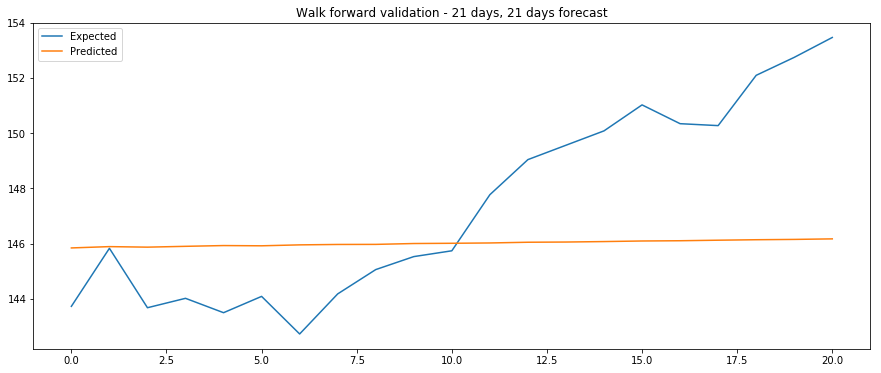

In [23]:
plot_walk_forward_validation(np.array(test), predictions, size, steps)

In [24]:
print('ARIMA[%d days, %d days forecast] - RMSE: %.3f' % (size, steps, rmse(predictions, test[:size])))

ARIMA[21 days, 21 days forecast] - RMSE: 3.575


In [25]:
size = 42 # approx. two month
steps = 42 # 42 days prediction
predictions = ARIMA_walk_forward(train, test, order, size=size, steps=steps)

predicted=[145.8435553  145.89119835 145.87188089 145.9018225  145.9293119
 145.92079075 145.95461228 145.96924949 145.97209891 146.00327252
 146.01193439 146.02357322 146.04958459 146.05712384 146.07408445
 146.09500674 146.10406978 146.12332468 146.1404732  146.15196611
 146.17146348 146.18642792 146.20018113 146.21886041 146.23296444
 146.24832698 146.2658772  146.27998202 146.29623207 146.31278565
 146.32731061 146.34387337 146.35974542 146.37478917 146.39130598
 146.40682139 146.42230155 146.43860922 146.45401595 146.46978263
 146.48585426 146.50130043], expected=[143.729996 145.830002 143.679993 144.020004 143.5      144.089996
 142.729996 144.179993 145.059998 145.529999 145.740005 147.770004
 149.039993 149.559998 150.080002 151.020004 150.339996 150.270004
 152.089996 152.740005 153.460007 150.559998 149.5      148.729996
 150.050003 157.139999 155.570007 156.389999 158.809998 160.080002
 161.059998 155.320007 157.479996 159.850006 161.600006 160.949997
 157.860001 157.5      

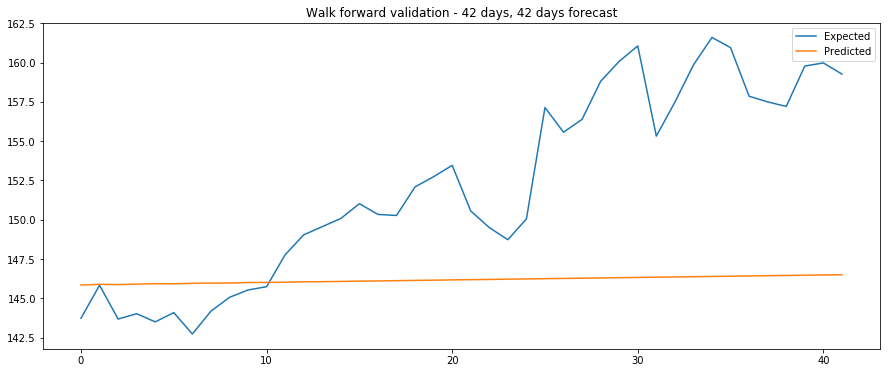

In [26]:
plot_walk_forward_validation(np.array(test), predictions, size, steps)

In [27]:
print('ARIMA[%d days, %d days forecast] - RMSE: %.3f' % (size, steps, rmse(predictions, test[:size])))

ARIMA[42 days, 42 days forecast] - RMSE: 8.323


In [28]:
size = 252 # approx. one year
steps = 252 # 252 days prediction
predictions = ARIMA_walk_forward(train, test, order, size=size, steps=steps)

predicted=[145.8435553  145.89119835 145.87188089 145.9018225  145.9293119
 145.92079075 145.95461228 145.96924949 145.97209891 146.00327252
 146.01193439 146.02357322 146.04958459 146.05712384 146.07408445
 146.09500674 146.10406978 146.12332468 146.1404732  146.15196611
 146.17146348 146.18642792 146.20018113 146.21886041 146.23296444
 146.24832698 146.2658772  146.27998202 146.29623207 146.31278565
 146.32731061 146.34387337 146.35974542 146.37478917 146.39130598
 146.40682139 146.42230155 146.43860922 146.45401595 146.46978263
 146.48585426 146.50130043 146.51720858 146.53309042 146.54863827
 146.56458164 146.58034394 146.59599823 146.61191622 146.62762325
 146.64335954 146.65922898 146.67492598 146.69071173 146.70653357
 146.72224507 146.738052   146.75383865 146.76957297 146.78538198
 146.80114834 146.8169038  146.83270505 146.84846349 146.86423394
 146.8800246  146.89578313 146.91156181 146.92734316 146.94310566
 146.95888722 146.97466222 146.99042958 147.00621067 147.02198237
 

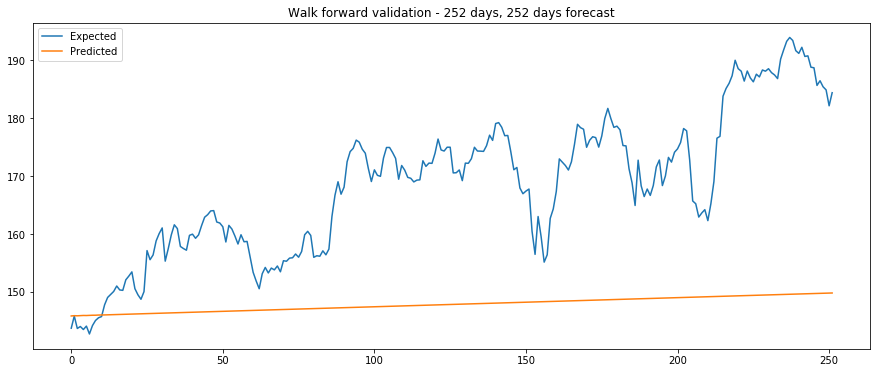

In [29]:
plot_walk_forward_validation(np.array(test), predictions, size, steps)

In [30]:
print('ARIMA[%d days, %d days forecast] - RMSE: %.3f' % (size, steps, rmse(predictions, test[:size])))

ARIMA[252 days, 252 days forecast] - RMSE: 23.484
